In [9]:
import numpy as np

np.random.seed(123)
#x = root height - internal node height
#y = internal node height
#T = 0,1,2 three topologies
#i = num of samples

# prob(x,y,T), T defines y and x  
def prob(x, y):
    Ne = 1
    p = (1/Ne) * np.exp(-3*y/Ne) * np.exp(-x/Ne)
    return p
    
# propose
def getProposal(x, y, T):
    x1 = x; y1 = y; T1 = T
    rand = np.random #.uniform(0, 1) [0, 1)
    if (rand.uniform(0, 1) > 0.5):
        #change x
        a = rand.uniform(0, 1) - 0.5
        x1 = x + a
        if (x1 < 0):
            #change T
            if (rand.uniform(0, 1) > 0):
                T1 = np.mod((T+1), 3)
            else:
                T1 = np.mod((T+2), 3)
            x1 = -x1
    else:
        #change y
        a = rand.uniform(0, 1) - 0.5
        y1 = y + a
    return x1, y1, T1

# access proposal
def accept(x, y, x1, y1):
    if (y1 < 0):
        return False #reject
    ratio = prob(x1,y1) / prob(x,y) 
    if (ratio > np.random.uniform(0, 1)):
        return True  #accept
    else:
        return False #reject


# MCMC sampling
samples = 50
x = y = 1 
T = i = 0
listX, listY, listT = ([] for i in range(3))
while i < samples:    
    x1, y1, T1 = getProposal(x, y, T)
    isAccepted = accept(x, y, x1, y1)
    if (isAccepted):
        listX.append(x1)
        listY.append(y1)
        listT.append(T1)
        i += 1

print("sample size = ", samples)
print("len(x)", len(listX), "== len(y)", len(listY), "is", len(listX) == len(listY))
print(*listX, sep=', ')
print(*listY, sep=', ')
print(*listT, sep=', ')

sample size =  50
len(x) 50 == len(y) 50 is True
0.7861393349503795, 1.219468969785563, 1.1848297385848632, 1, 1, 0.6824917304535, 1.031827587096866, 1.2244553248606351, 0.8229589138531782, 1, 1, 1, 1.1239529517921112, 1, 1, 1.1128945257629677, 1.1030601284109274, 1, 1.375456841795175, 1.0859365525622129, 1.3423424376202573, 0.743666374536874, 0.5957125166123871, 1.2234163581899549, 1.0567851923942886, 1, 1.054383249717772, 1.3416699969127164, 1, 1.4953584820340176, 1.0931769165622212, 1, 1, 1, 1.346506225270722, 0.8848378112757611, 1, 1, 0.5026880645743207, 0.7076358611963245, 1, 1, 1, 1, 1, 1, 1, 0.5849041631918176, 0.83706638344761, 1.0740638251499646
1, 1, 1, 0.8431780161508694, 0.5596778966095683, 1, 1, 1, 1, 0.7937140463888294, 0.9337011726795282, 0.925830290295828, 1, 0.9148262119536318, 0.9830342642627043, 1, 1, 0.8041207890271841, 1, 1, 1, 1, 1, 1, 1, 1.195529528770911, 1, 1, 0.8047680734110975, 1, 1, 0.8988762927261565, 1.013128154199002, 0.6308949506640807, 1, 1, 0.671081829

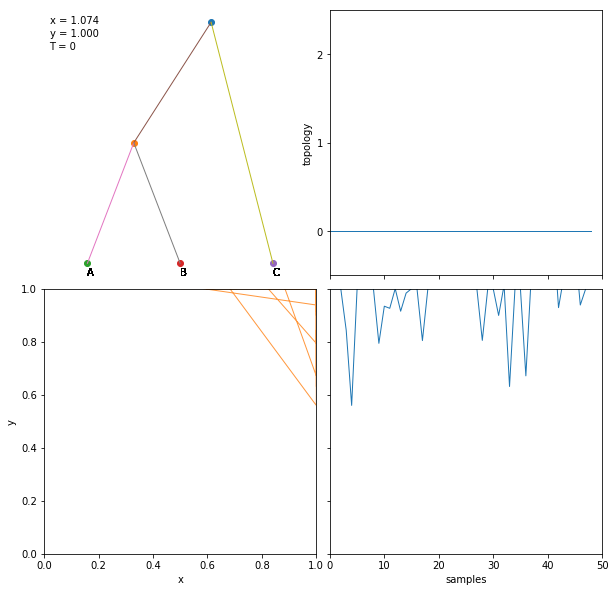

In [22]:
import matplotlib.pyplot as plt
from matplotlib import animation

fig = plt.figure(figsize=(10,10))
x_width = y_width = (0, 1)
xy_width = (-0.1, 2.1)
states_width = (0, samples)
# the tree plan
ax1 = fig.add_subplot(221, xlim=xy_width, ylim=xy_width)
ax1.axis('off')
ax2 = fig.add_subplot(222, xlim=states_width, ylim=(-0.5, 2.5), ylabel='topology')
ax2.set_xticklabels([])
ax2.yaxis.set_ticks(np.arange(0, 3, step=1))
# x, y
ax3 = fig.add_subplot(223, xlim=x_width, ylim=y_width, xlabel='x', ylabel='y')
ax4 = fig.add_subplot(224, xlim=states_width, ylim=y_width, xlabel='samples')
ax4.set_yticklabels([])
fig.subplots_adjust(wspace=0.05, hspace=0.05)

line1, = ax2.plot([], [], lw=1)
line2, = ax4.plot([], [], lw=1)
# dot
line3, = ax3.plot([], [], 'o', lw=3)
line4, = ax3.plot([], [], lw=1, alpha=.8)
# tree topology based on (A,B),C => A 3, B 4, C 5, AB, 2, ABC 1
node1, = ax1.plot([], [], 'o', lw=2)
node2, = ax1.plot([], [], 'o', lw=3)
node3, = ax1.plot([], [], 'o', lw=2)
node4, = ax1.plot([], [], 'o', lw=2)
node5, = ax1.plot([], [], 'o', lw=2)
edge12, = ax1.plot([], [], lw=1)
edge23, = ax1.plot([], [], lw=1)
edge24, = ax1.plot([], [], lw=1)
edge15, = ax1.plot([], [], lw=1)
lines = [line1, line2, line3, line4, edge12, edge23, edge24, edge15, 
         node1, node2, node3, node4, node5]
# text
x_text = ax1.text(0.02, 0.95, '', transform=ax1.transAxes)
y_text = ax1.text(0.02, 0.90, '', transform=ax1.transAxes)
T_text = ax1.text(0.02, 0.85, '', transform=ax1.transAxes)

x3 = 0.25
x4 = 1.0
x5 = 1.75
# tree T=0 : (A,B),C => A 3, B 4, C 5
# tree T=1 : (A,C),B => A 3, B 5, C 4
# tree T=2 : (B,C),A or (C,B),A => A 5, B 3, C 4
def labelTreeByTopology(T):
    #change label based on T
    if (T==0):
        ax1.annotate('A', (x3, -0.1))
        ax1.annotate('B', (x4, -0.1))
        ax1.annotate('C', (x5, -0.1))
    elif (T==1):
        ax1.annotate('A', (x3, -0.1))
        ax1.annotate('B', (x5, -0.1))
        ax1.annotate('C', (x4, -0.1))
    elif (T==2):
        ax1.annotate('A', (x5, -0.1))
        ax1.annotate('B', (x3, -0.1))
        ax1.annotate('C', (x4, -0.1))
    else:
        raise Exception("Not recognised topology T =", T)    

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Node2x = 0.625
Rootx = 1.25
def animate(i):
    line1.set_data(range(i), listT[:i])
    line2.set_data(range(i), listY[:i])
    line3.set_data(listX[i], listY[i])
    line4.set_data(listX[:i], listY[:i])
    #tree 
    node1.set_data(Rootx, 2) # root
    node2.set_data(Node2x, listY[i]) 
    node3.set_data(Ax, 0) # A
    node4.set_data(Bx, 0) # B
    node5.set_data(Cx, 0) # C
    edge12.set_data([Rootx, Node2x], [2, listY[i]])
    edge23.set_data([Node2x, Ax], [listY[i], 0])
    edge24.set_data([Node2x, Bx], [listY[i], 0])
    edge15.set_data([Rootx, Cx], [2, 0])
    # text
    x_text.set_text('x = %.3f' % listX[i])
    y_text.set_text('y = %.3f' % listY[i])
    T_text.set_text('T = %.0f' % listT[i])
    labelTreeByTopology(listT[i])
    return lines

# interval : Delay between frames in milliseconds. Defaults to 200.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=samples, 
                               interval=5, blit=True, repeat=True)

anim.save('TreeSpace3Taxa.mp4', fps=1, extra_args=['-vcodec', 'libx264'])
plt.show()

